---
title: "Turning Jupyter notebooks into Jekyll blog posts"

---

One functionality I really want for my blog is to be able to easily turn Jupyter notebooks
into blog posts. I do much exploration in notebooks, so being able to use them as the base
of blog posts would be great. I am hoping to find a solution which works well with the
Minimal Mistakes theme I'm using to make the result fit nicely with the remaining design of
the website. I don't think I need a very complicated solution - a static version of the
notebook like it is for example used by `nbsphinx` should be enough. I used `nbsphinx`
recently to include usage examples into the `physical_validation` documentation (see e.g.
[here](https://physical-validation.readthedocs.io/en/stable/examples/kinetic_energy_distribution.html)),
and quite liked the result.
If I get this to work nicely, I do have a few additional features on my wish list, however:
* An automatic link to the source notebook on GitHub, which would allow readers to easily
  download the notebook and run it locally.
* An integration with Google Colab, which would allow readers to run the notebook online.
* Hiding certain input or output cells would allow me to highlight specific things while
  hiding less interesting boilerplate code without completely removing it.

# Getting started
There are multiple blog posts explaining how to turn Jupyter notebooks into either Markdown
or HTML files (e.g. [1](https://cduvallet.github.io/posts/2018/03/ipython-notebooks-jekyll),
[2](https://jaketae.github.io/blog/jupyter-automation/),
[3](http://www.kasimte.com/adding-and-including-jupyter-notebooks-as-jekyll-blog-posts))
using `nbconvert`. If there are plots in the notebook, `nbconvert` turns them into png images
which are then embedded in the Markdown document. Using the resulting files as Jekyll posts
does then only require adjusting a few things like headers or image paths, moving the files
in the right folder, and upload the result. This sounds like a viable option!

There are several additional options I found which don't perfectly fit for what I'm trying
to achieve, but look very interesting:
* [`fastpages`](https://github.com/fastai/fastpages), a blogging platform which supports
  Markdown and Jupyter notebooks (and even Word docs!). This looks extremely powerful, but
  after some exploration I found that trying to fit the result into my existing site did not
  yield satisfactory results. I think this is a great project, though!
* [Jupyter Book](https://jupyterbook.org) turns notebooks into beautiful books
  or articles. This looks amazing for standalone projects, but I don't see an easy way to fit
  the result into my existing page.
* [Jekyll Jupyter Notebook plugin](https://github.com/red-data-tools/jekyll-jupyter-notebook)
  allows to embed Jupyter notebooks in Markdown documents used by Jekyll. This seems
  really useful, but is not exactly what I'm looking for here - I would prefer to write the
  entire post in a notebook rather than including a notebook into a Markdown post.

I decided to use `nbconvert` to create Markdown files (and not directly HTML). My reasoning was
that this approach would have a higher likelihood to create posts with the right look, as they
would be processed by Jekyll in the same way as the rest of the site. This also meant that I
could write the YAML front matter for the posts in a Markdown cell, which should then be left
alone by `nbconvert`. Finally, it would also mean that the automatic excerpt function of the
Minimal Mistakes theme (taking the first paragraph as an excerpt if it isn't defined differently)
should work properly.

# Turning a Jupyter notebook into a Markdown Jekyll post

## Naming and file organization
When converting a Jupyter notebook to Markdown, `nbconvert` will by default write a Markdown file
with the same base name as the notebook, changing only the file extension. The Markdown conversion
of a notebook named `basename.ipynb` will be saved in a file called `basename.md`. Since Jekyll
blog posts are required to be named as `YEAR-MONTH-DAY-title.md` (
[reference](https://jekyllrb.com/docs/posts/)), it is easiest to follow that naming
for notebooks. A notebook which should become a blog post should hence be named
`YEAR-MONTH-DAY-title.ipynb`.

Blog posts on Jekyll sites live in the `_posts` folder. I decided to follow the example of `fastpages`
and create a `_notebooks` folder in which to store the notebooks. I will then move the resulting
Markdown file into the `_posts` folder, where it will be picked up by Jekyll. I will also move the
images into the `assets/images/` folder, which is the default location for images.

## A bash script to convert Jupyter notebooks to Markdown Jekyll posts
As a recap, here's the steps we need to take:
* Use `nbconvert` to convert Jupyter notebook to Markdown
* Change image paths from local paths to absolute paths in `assets/images/`
* Move the resulting Markdown file into the `_posts` folder
* Move the image folder to `assets/images/`.

This can easily be done by a few lines of bash with some perl support (and a call to `jupyter nbconvert`
which does the heavy-lifting, of course):
```bash
# Get file name without extension
filename="${notebook_file%.*}"
# Name of Markdown file will be base name + ".md"
md_notebook="${filename}.md"
# Convert notebook to Markdown
jupyter nbconvert "$notebook_file" --to markdown
# Fix image links to point to a place where Jekyll will pick up the images
{% raw %}perl -pi -e 's/\[png\]\(/[png]({{ site.url }}{{ site.baseurl }}\/assets\/images\//g' "$md_notebook"{% endraw %}
# Move Markdown notebook to _posts/ directory
mv "$md_notebook" "${root_directory}/_posts/"
# Move images to a assets such that Jekyll finds them
mv "${filename}_files" "${root_directory}/assets/images/"
```

## Front matter
Since `nbconvert` does not change the content of Markdown cells, I can simply define the first cell of the
notebook to be a Markdown cell and write the YAML front matter there. For example, the first cell of this
notebook reads
```
---
title: "Turning Jupyter notebooks into Jekyll blog posts"
toc: true
category: "Blogging platform"
tags: ["Jekyll", "Jupyter", "Minimal Mistakes"]
badges: true
---
```

`nbconvert` will simply print that as the first lines of the created Markdown file. Jekyll will then interpret
these lines as the YAML front matter, and will render the rest of the post based on the settings set here. I'm pretty
satisfied with this solution: It's easy and intuitive to write, and it doesn't impair the functionality of
the notebook in any way.

# Links to GitHub and Google Colab
Having a way to get the source notebook on GitHub or run in on Google Colab is a great feature that I
really enjoy on other pages, so I'd love to have that on my blog. [`fastpages`](https://github.com/fastai/fastpages)
has built-in functionality to add badges that I think works and looks great, so I will try to replicate
some of that behavior here.

## Links
Links to files on GitHub do generally have the form 
`https://github.com/<GitHub username or organization>/<repository name>/blob/<branch>/<file path>`. 

To run notebooks stored on GitHub in Google Colab, the link has the form
`https://colab.research.google.com/github/<GitHub username or organization>/<repository name>/blob/<branch>/<file path>`.

Knowing this, it's easy to create links to the notebook generating a blog post.
I am serving my site from the `main` branch, and in my file
organization mentioned above the notebook is going to be under `_notebooks/<filename>`. Note that the
repository name can be set in the Jekyll configuration, so if the `repository` tag was set in `_config.yml`, the
repository information in the link can be filled by Jekyll. To achieve this, I simply replaced 
`<GitHub username or organization>/<repository name>` by `{% raw %}{{ site.repository }}{% endraw %}`. So my links
are going to read<br>
`https://github.com/{% raw %}{{site.repository}}{% endraw %}/blob/main/_notebooks/<filename>`<br>
for GitHub and<br>
`https://colab.research.google.com/github/{% raw %}{{site.repository}}{% endraw %}/blob/main/_notebooks/<filename>`<br>
for Google Colab.

## Badges
Google Colab offers a badge which looks like this:

![Google Colab](https://colab.research.google.com/assets/colab-badge.svg)

I didn't find a comparable badge for GitHub, but using [shields.io](https://shields.io) it's easy to create one:

![GitHub](https://img.shields.io/static/v1?label=&message=Open%20on%20GitHub&logo=github&color=lightgray&labelColor=gray)

## Including badges in blog posts
To include the badges in blog posts, I decided, again inspired by `fastpages`, to add a new layout called `notebook` to Minimal Mistakes. That new
layout is the same as the default `single` layout, but adds the badges. This solution has a couple of nice properties:
* It's update friendly: If the `single` layout is changed, `notebook` is updated accordingly.
* It works with the default excerpts: By default, the excerpt which is used to create the pagination links is done by
  taking the first few lines of the content of the post. If the badges were part of the content, the standard excerpt
  of all posts would start with the (non-rendered) code for the badges. By introducing the new layout and making the
  badges part of the layout rather than the content, we are avoiding this problem.
  
The new layout is only a few lines long and lives in `_layouts/notebook.html`:
```
---
layout: single
---
{% raw %}
{% if page.badges %}
  <hr>
  <div style="display: flex; justify-content: center;">
    <div style="padding-left: 0.5em; padding-right: 0.5em;">
      <a href="https://github.com/{{ site.repository }}/blob/main/_notebooks/{{ page.filename }}" target="_blank">
        <img src="https://img.shields.io/static/v1?label=&message=Open%20on%20GitHub&logo=github&color=lightgray&labelColor=gray" alt="Open on GitHub">
      </a>
    </div>
    <div style="padding-left: 0.5em; padding-right: 0.5em;">
      <a href="https://colab.research.google.com/github/{{ site.repository }}/blob/main/_notebooks/{{ page.filename }}" target="_blank">
        <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab">
      </a>
    </div>
  </div>
  <hr>
{% endif %}

{{ content }}{% endraw %}
```

The first line makes the layout inherit all properties of the `single` layout. Before including the page content
on the last line, there are a few lines of HTML code with some Jekyll tags. The HTML code gets only included if
`page.badges` is true. If it gets included, it adds the two tags with links as described above between two
horizontal lines `<hr>`.

To make this work seamlessly, I extended the bash code above by a few lines to add the `notebook` layout and the
file name to the YAML front matter automatically when converting Jupyter notebook.

# Running the conversion as a GitHub action
I am already using GitHub actions to deploy my website to the `gh_pages` branch. The workflow is very simple, it
is checking out the current repository, building the website and pushing the result to `gh_pages`. I therefore
decided that all the machinery of turning Jupyter notebooks in blog posts should live in a separate action,
meaning that there wouldn't need to be any changes to my site repository to enable this functionality - except
for adding notebooks to the `_notebooks` folder, of course.

The action I wrote lives at [ptmerz/jupyter-minimal-mistakes](https://github.com/ptmerz/jupyter-minimal-mistakes)
and is ready to be used by others (but has only been tested by myself, so has certainly tons of potential
improvements and probably a few bugs). The README has more details on its use. I also wrote some more details
about creating that action at
[A GitHub action to turn Jupyter notebooks into Minimal Mistakes Jekyll blog posts]({% post_url 2021-12-17-github-action %}).

# Running the conversion locally
While I think that the GitHub action is the perfect way to handle this upstream, I sometimes want to run the
conversion locally, mostly to be able to preview how a post looks using my local Jekyll installation. To do
that, I have a clone of the repository of the GitHub action next to my local clone of my website repository.
The first time I am using it, I need to copy the layout file into my website repository:
```
mkdir -p username.github.io/_layouts
cp jupyter-minimal-mistakes/_layouts/notebook.html username.github.io/_layouts/notebook.html
```
Then, from the site folder, I can simply call the `convert_notebooks.sh` script:
```
cd username.github.io
sh ../jupyter-minimal-mistakes/convert_notebooks.sh
```
This feels a tad hack-y, but it works perfectly, so I'm OK with that for now!

# Features
## Math mode
Math mode works in the Markdown part of the notebook, both inline mode $a^2 + b^2 = c^2$ and display mode

$$ i \hbar \frac{\partial}{\partial t}\Psi(\mathbf{r},t) = \hat H \Psi(\mathbf{r},t) $$

## Matplotlib plot

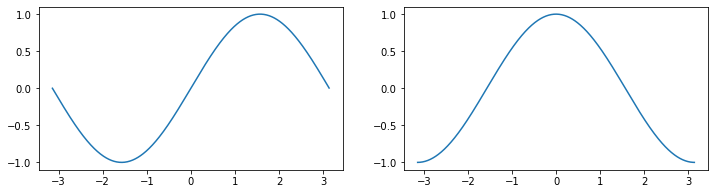

In [1]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(-np.pi, np.pi, 0.01)
fig, ax = plt.subplots(1, 2, figsize=(12, 3))
ax = ax.flatten()

ax[0].plot(x, np.sin(x))
ax[1].plot(x, np.cos(x))

plt.show()

## Code with output

In [1]:
for word in ["one", "two", "three"]:
    print(word)

one
two
three


# Future work
There are two small details I might look into some day:
* I am not completely satisfied by the design of the code output. I would like to make it easier to distinguish
  between the input of a code cell and its output.
* I would love to have a way to hide / collapse input or output of code cells like Jupyter Book. I think this
  feature would allow to write concise posts focusing on the essential parts. It is challenging, though,
  as it would require to either convert the notebook directly into HTML, or to further process the Markdown
  file created by `jupyter nbconvert`.

# Conclusion
I am really happy with this solution. I can write blog posts as Jupyter notebooks, needing only to add a
first cell with the YAML front matter. I can commit these notebooks to GitHub,
and the GitHub actions take care of the rest. The results fit perfectly in the Minimal Mistake theme, and
allow readers to view the original notebook on GitHub or in Colab.